In [ ]:
import pandas as pd

In [ ]:
data = pd.read_csv('Google Stock Price.csv', thousands=',')

In [ ]:
data.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2017,778.81,789.63,775.80,786.14,1657300
1,1/4/2017,788.36,791.34,783.16,786.90,1073000
2,1/5/2017,786.08,794.48,785.02,794.02,1335200
3,1/6/2017,795.26,807.90,792.20,806.15,1640200
4,1/9/2017,806.40,809.97,802.83,806.65,1272400


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

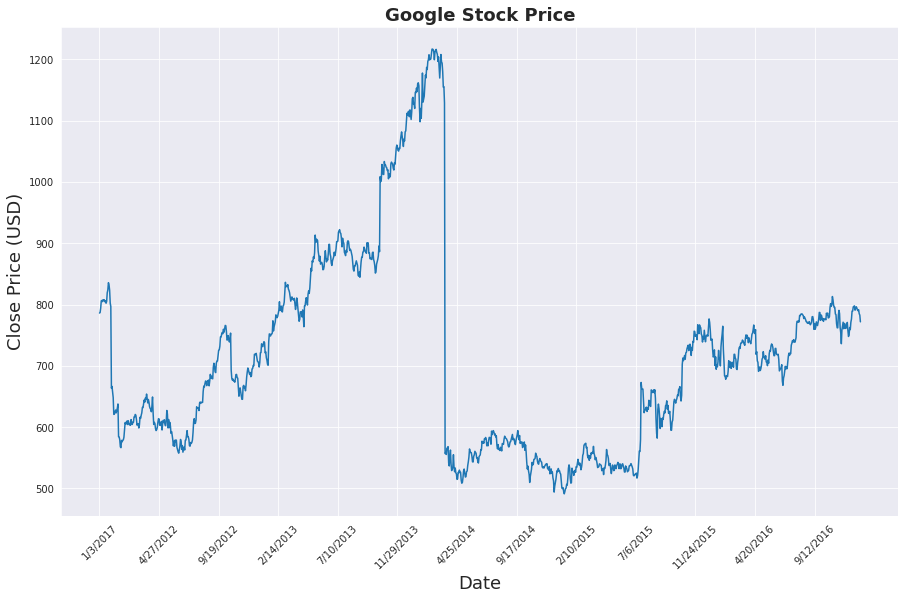

In [ ]:
sns.set_style('darkgrid')
plt.figure(figsize=(15,9))
plt.plot(data[['Close']])
plt.xticks(range(0,data.shape[0], 100), data['Date'].loc[::100], rotation=45)
plt.title('Google Stock Price', fontsize=18, fontweight='bold')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price (USD)', fontsize=18)
plt.show()

In [ ]:
price = data[['Close']]
price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1278 entries, 0 to 1277
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1278 non-null   float64
dtypes: float64(1)
memory usage: 10.1 KB


In [ ]:
price.shape

(1278, 1)

In [ ]:
price.values.reshape(-1,1).shape

(1278, 1)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler(feature_range=(-1,1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
import numpy as np

In [ ]:
def split_data(stock, lookback):
  data_raw = stock.to_numpy()
  data = []

  # Create all possible sequences of length seq_len
  for index in range(len(data_raw)-lookback):
    data.append(data_raw[index: index+lookback])

  data = np.array(data)
  test_set_size = int(np.round(0.2*data.shape[0]))
  train_set_size = data.shape[0] - test_set_size

  x_train = data[:train_set_size,:-1,:]
  y_train = data[:train_set_size,-1,:]
    
  x_test = data[train_set_size:,:-1]
  y_test = data[train_set_size:,-1,:]
    
  return [x_train, y_train, x_test, y_test]

In [ ]:
lookback = 20
x_train, y_train, x_test, y_test = split_data(price, lookback)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (1006, 19, 1)
y_train.shape =  (1006, 1)
x_test.shape =  (252, 19, 1)
y_test.shape =  (252, 1)


In [ ]:
import torch
import torch.nn as nn

In [ ]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)

In [ ]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [ ]:
model = LSTM(input_dim, hidden_dim, num_layers, output_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

10
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


In [ ]:
import time

In [ ]:
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for epoch in range(num_epochs):
  y_train_pred = model(x_train)

  loss = criterion(y_train_pred, y_train_lstm)
  print('Epoch ', epoch, 'MSE: ', loss.item())
  hist[epoch] = loss.item()

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

training_time = time.time() - start_time
print('Training time: {}'.format(training_time))

Epoch  0 MSE:  0.40171098709106445
Epoch  1 MSE:  0.31036674976348877
Epoch  2 MSE:  0.23635411262512207
Epoch  3 MSE:  0.2337878793478012
Epoch  4 MSE:  0.197612464427948
Epoch  5 MSE:  0.1703258603811264
Epoch  6 MSE:  0.1519712209701538
Epoch  7 MSE:  0.11649788916110992
Epoch  8 MSE:  0.07751382142305374
Epoch  9 MSE:  0.08536859601736069
Epoch  10 MSE:  0.04434652999043465
Epoch  11 MSE:  0.06883712112903595
Epoch  12 MSE:  0.05262162536382675
Epoch  13 MSE:  0.04121753200888634
Epoch  14 MSE:  0.0415692962706089
Epoch  15 MSE:  0.02882353588938713
Epoch  16 MSE:  0.019736919552087784
Epoch  17 MSE:  0.020669493824243546
Epoch  18 MSE:  0.024135587736964226
Epoch  19 MSE:  0.02498750388622284
Epoch  20 MSE:  0.02333567664027214
Epoch  21 MSE:  0.021459566429257393
Epoch  22 MSE:  0.02073270082473755
Epoch  23 MSE:  0.020826658234000206
Epoch  24 MSE:  0.02043294534087181
Epoch  25 MSE:  0.018518630415201187
Epoch  26 MSE:  0.01559610664844513
Epoch  27 MSE:  0.01327691413462162
Ep

In [ ]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

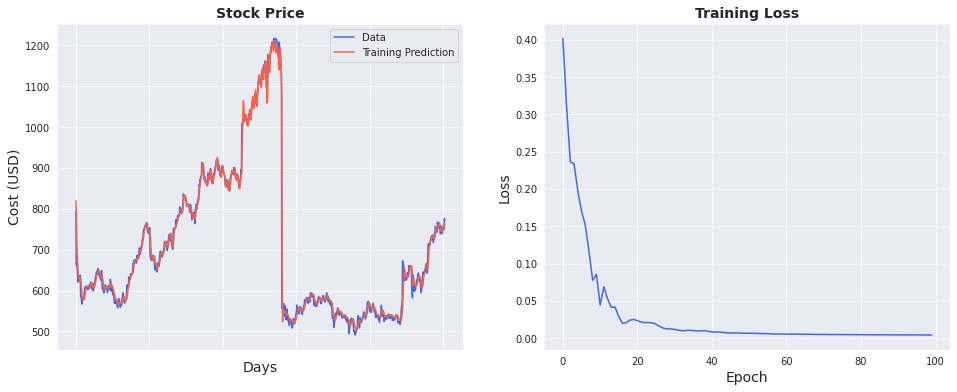

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1,2,1)
ax = sns.lineplot(x=original.index, y=original[0], label='Data', color='royalblue')
ax = sns.lineplot(x=predict.index, y=predict[0], label='Training Prediction', color='tomato')
ax.set_title('Stock Price', size=14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)

plt.subplot(1,2,2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [ ]:
import math
from sklearn.metrics import mean_squared_error

In [ ]:
# Make predictions
y_test_pred = model(x_test)

# Invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# Calculate root MSE
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print(f'Train score {trainScore:.2f} RMSE')
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print(f'Test score {testScore:.2f} RMSE')

lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)

Train score 23.48 RMSE
Test score 11.98 RMSE


In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(price)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(price)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+lookback-1:len(price)-1, :] = y_test_pred

original = scaler.inverse_transform(price['Close'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                    mode='lines',
                    name='Train prediction')))
fig.add_trace(go.Scatter(x=result.index, y=result[1],
                    mode='lines',
                    name='Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                    mode='lines',
                    name='Actual Value')))
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='white',
        linewidth=2,
    ),
    yaxis=dict(
        title_text='Close (USD)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'

)



annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (LSTM)',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import keras

In [ ]:
lookback = 20
x_train_keras, y_train_keras, x_test_keras, y_test_keras = split_data(price, lookback)
print('x_train.shape = ',x_train_keras.shape)
print('y_train.shape = ',y_train_keras.shape)
print('x_test.shape = ',x_test_keras.shape)
print('y_test.shape = ',y_test_keras.shape)

x_train.shape =  (1006, 19, 1)
y_train.shape =  (1006, 1)
x_test.shape =  (252, 19, 1)
y_test.shape =  (252, 1)


In [ ]:
import tensorflow as tf

In [ ]:
regression = Sequential()
regression.add(LSTM(units=50, return_sequences=True, input_shape=(x_train_keras.shape[1],1)))
regression.add(Dropout(0.2))

regression.add(LSTM(units=50, return_sequences=True))
regression.add(Dropout(0.2))

regression.add(LSTM(units=50, return_sequences=True))
regression.add(Dropout(0.2))

regression.add(LSTM(units=50))
regression.add(Dropout(0.2))

regression.add(Dense(units=1))

optim = tf.keras.optimizers.Adam(learning_rate=0.01)
regression.compile(optimizer=optim, loss='mean_squared_error', metrics=['accuracy'])

In [ ]:
regression.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 19, 50)            10400     
                                                                 
 dropout_4 (Dropout)         (None, 19, 50)            0         
                                                                 
 lstm_5 (LSTM)               (None, 19, 50)            20200     
                                                                 
 dropout_5 (Dropout)         (None, 19, 50)            0         
                                                                 
 lstm_6 (LSTM)               (None, 19, 50)            20200     
                                                                 
 dropout_6 (Dropout)         (None, 19, 50)            0         
                                                                 
 lstm_7 (LSTM)               (None, 50)               

In [ ]:
from keras.callbacks import History

In [ ]:
history = History()
history = regression.fit(x_train_keras, y_train_keras, batch_size=30, epochs=100, callbacks=[history])

Epoch 1/100
34/34 [==============================] - 8s 38ms/step - loss: 0.0960 - accuracy: 9.9404e-04
Epoch 2/100
34/34 [==============================] - 1s 37ms/step - loss: 0.0301 - accuracy: 0.0000e+00
Epoch 3/100
34/34 [==============================] - 1s 39ms/step - loss: 0.0226 - accuracy: 9.9404e-04
Epoch 4/100
34/34 [==============================] - 1s 39ms/step - loss: 0.0304 - accuracy: 9.9404e-04
Epoch 5/100
34/34 [==============================] - 1s 38ms/step - loss: 0.0177 - accuracy: 9.9404e-04
Epoch 6/100
34/34 [==============================] - 1s 38ms/step - loss: 0.0148 - accuracy: 9.9404e-04
Epoch 7/100
34/34 [==============================] - 1s 37ms/step - loss: 0.0169 - accuracy: 9.9404e-04
Epoch 8/100
34/34 [==============================] - 1s 38ms/step - loss: 0.0128 - accuracy: 9.9404e-04
Epoch 9/100
34/34 [==============================] - 1s 38ms/step - loss: 0.0124 - accuracy: 9.9404e-04
Epoch 10/100
34/34 [==============================] - 1s 37ms/st

In [ ]:
print(history.history)

{'loss': [0.09597685188055038, 0.03013024665415287, 0.02260112203657627, 0.030383149161934853, 0.017695235088467598, 0.014821193180978298, 0.01691647246479988, 0.01282869279384613, 0.012360148131847382, 0.01543394848704338, 0.011142769828438759, 0.010562038980424404, 0.011771725490689278, 0.010755600407719612, 0.009448331780731678, 0.00878971442580223, 0.011952420696616173, 0.011021420359611511, 0.011553235352039337, 0.009804111905395985, 0.008584636263549328, 0.011270400136709213, 0.010911064222455025, 0.0096234530210495, 0.011320974677801132, 0.010846594348549843, 0.009318025782704353, 0.008697251789271832, 0.009110882878303528, 0.010009863413870335, 0.00871262140572071, 0.010143456049263477, 0.00992431491613388, 0.009152930229902267, 0.010985047556459904, 0.009081782773137093, 0.008394698612391949, 0.008088437840342522, 0.00908363051712513, 0.009044111706316471, 0.011384252458810806, 0.008229313418269157, 0.00770768104121089, 0.00811290368437767, 0.010158751159906387, 0.009725830517

In [ ]:
train_predict_keras = regression.predict(x_train_keras)

In [ ]:
train_predict_keras.shape

(1006, 1)

In [ ]:
predict = pd.DataFrame(scaler.inverse_transform(train_predict_keras))
original = pd.DataFrame(scaler.inverse_transform(y_train_keras))

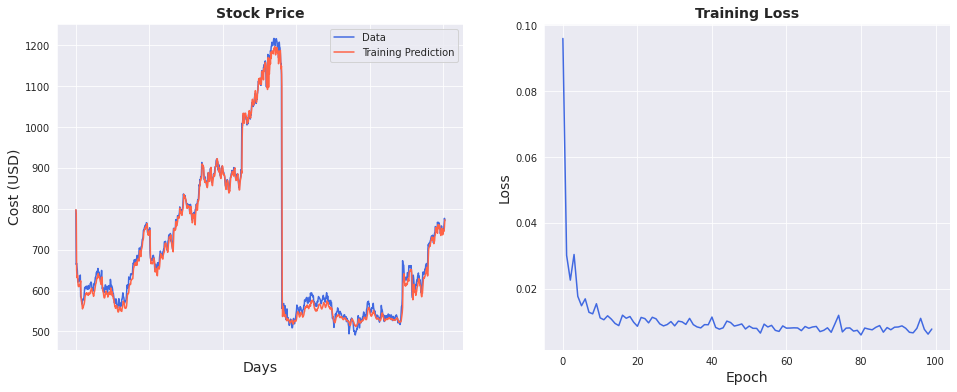

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1,2,1)
ax = sns.lineplot(x=original.index, y=original[0], label='Data', color='royalblue')
ax = sns.lineplot(x=predict.index, y=predict[0], label='Training Prediction', color='tomato')
ax.set_title('Stock Price', size=14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)

plt.subplot(1,2,2)
ax = sns.lineplot(data=history.history.get('loss'), color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [ ]:
# Make predictions
test_predict_keras = regression.predict(x_test_keras)

# Invert predictions
train_predict_keras = scaler.inverse_transform(train_predict_keras)
y_train_keras = scaler.inverse_transform(y_train_keras)
test_predict_keras = scaler.inverse_transform(test_predict_keras)
y_test = scaler.inverse_transform(y_test_keras)

# Calculate root MSE
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print(f'Train score {trainScore:.2f} RMSE')
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print(f'Test score {testScore:.2f} RMSE')

Train score 23.48 RMSE
Test score 11.98 RMSE


In [ ]:
# shift train predictions for plotting
trainPredictPlot_keras = np.empty_like(price)
trainPredictPlot_keras[:, :] = np.nan
trainPredictPlot_keras[lookback:len(train_predict_keras)+lookback, :] = train_predict_keras

# shift test predictions for plotting
testPredictPlot_keras = np.empty_like(price)
testPredictPlot_keras[:, :] = np.nan
testPredictPlot_keras[len(train_predict_keras)+lookback-1:len(price)-1, :] = test_predict_keras

original = scaler.inverse_transform(price['Close'].values.reshape(-1,1))

predictions_keras = np.append(trainPredictPlot_keras, testPredictPlot_keras, axis=1)
predictions_keras = np.append(predictions_keras, original, axis=1)
result_keras = pd.DataFrame(predictions_keras)

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result_keras.index, y=result_keras[0],
                    mode='lines',
                    name='Train prediction')))
fig.add_trace(go.Scatter(x=result_keras.index, y=result_keras[1],
                    mode='lines',
                    name='Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result_keras.index, y=result_keras[2],
                    mode='lines',
                    name='Actual Value')))
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='white',
        linewidth=2,

    ),
    yaxis=dict(
        title_text='Close (USD)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'

)



annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (LSTM)',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
fig.update_layout(annotations=annotations)
fig.show()